In [9]:
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output

In [10]:
DOWN = 0
UP = 1
LEFT = 2
RIGHT = 3
actions = [DOWN, UP, LEFT, RIGHT]

ALPHA0 = 0.4
GAMMA = 0.9
EPISODES = 5000
EPSILON0 = 0.1
TAU = 0.3


## Environment Creation

Environment paramters

In [ ]:
num_cols = 10
num_rows = 10
num_actions = 4
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state1 = np.array([[0,4]])
start_state2 = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

In [22]:
def create_gridworld(num_rows, num_cols, start_state, goal_states, obstructed_states, bad_states, restart_states, wind=False, p_good_transition=0.7, bias=0.5):
    gw = GridWorld(num_rows=num_rows,
                   num_cols=num_cols,
                   start_state=start_state,
                   goal_states=goal_states,
                   wind=wind)
    
    gw.add_obstructions(obstructed_states=obstructed_states,
                        bad_states=bad_states,
                        restart_states=restart_states)
    
    gw.add_rewards(step_reward=-1,
                   goal_reward=10,
                   bad_state_reward=-6,
                   restart_state_reward=-100)
    
    gw.add_transition_probability(p_good_transition=p_good_transition,
                                  bias=bias)
    
    env = gw.create_gridworld()
    
    return env


### 1. wind=False(clear), p = 0.7(stochastic step)

In [23]:
env_stochastic1 = create_gridworld(num_rows=num_rows,
                         num_cols=num_cols,
                         start_state=start_state1,
                         goal_states=goal_states,
                         obstructed_states=obstructions,
                         bad_states=bad_states,
                         restart_states=restart_states,
                         wind=False,
                         p_good_transition=0.7,
                         bias=0.5)

env_stochastic2 = create_gridworld(num_rows=num_rows,
                         num_cols=num_cols,
                         start_state=start_state2,
                         goal_states=goal_states,
                         obstructed_states=obstructions,
                         bad_states=bad_states,
                         restart_states=restart_states,
                         wind=False,
                         p_good_transition=0.7,
                         bias=0.5)

### 2. wind=False(clear), p = 1.0(deterministic step)

In [24]:
env_det1 = create_gridworld(num_rows=num_rows,
                         num_cols=num_cols,
                         start_state=start_state1,
                         goal_states=goal_states,
                         obstructed_states=obstructions,
                         bad_states=bad_states,
                         restart_states=restart_states,
                         wind=False,
                         p_good_transition=1.0,
                         bias=0.5)

env_det2 = create_gridworld(num_rows=num_rows,
                         num_cols=num_cols,
                         start_state=start_state1,
                         goal_states=goal_states,
                         obstructed_states=obstructions,
                         bad_states=bad_states,
                         restart_states=restart_states,
                         wind=False,
                         p_good_transition=1.0,
                         bias=0.5)


### 3. wind=True(windy), p = 1.0(deterministic step).


In [20]:
env_windy1 = create_gridworld(num_rows=num_rows,
                         num_cols=num_cols,
                         start_state=start_state1,
                         goal_states=goal_states,
                         obstructed_states=obstructions,
                         bad_states=bad_states,
                         restart_states=restart_states,
                         wind=True,
                         p_good_transition=1.0,
                         bias=0.5)

env_windy2 = create_gridworld(num_rows=num_rows,
                         num_cols=num_cols,
                         start_state=start_state2,
                         goal_states=goal_states,
                         obstructed_states=obstructions,
                         bad_states=bad_states,
                         restart_states=restart_states,
                         wind=True,
                         p_good_transition=1.0,
                         bias=0.5)

### Q Values

We use a 2D array to represent Q values. The first index is the state number and second index is the action.

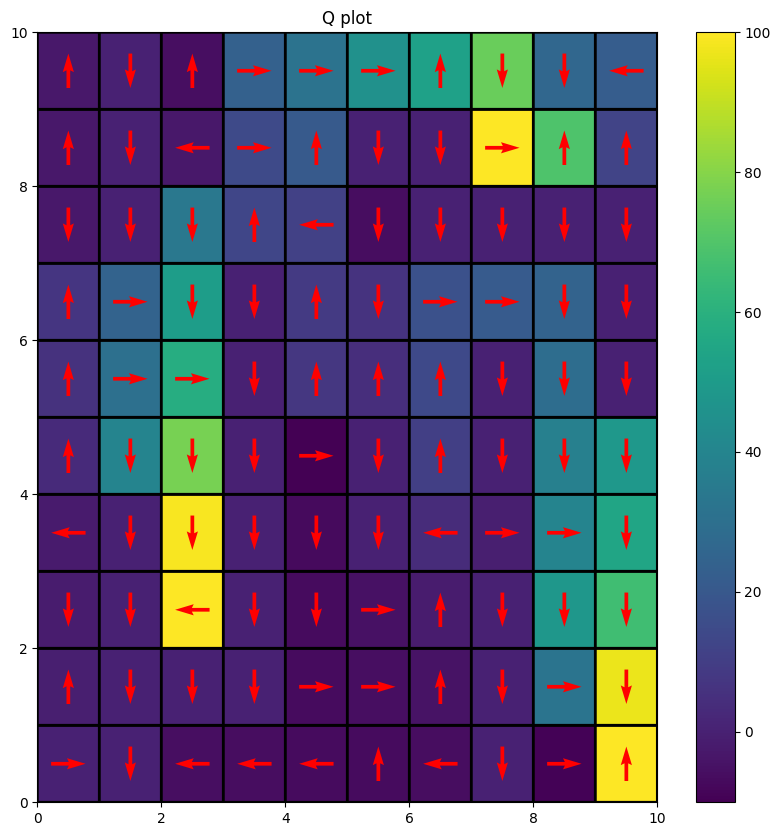

(100, 4)

In [12]:
Q_init = np.zeros((gw.num_states, gw.num_actions))

plot_Q(Q_init)

### Choice of actions

In [13]:
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy
def choose_action_epsilon(Q, state, epsilon, rg=rg):

    # print(Q[state[0], state[1]])
    
    action_values=Q[state]
    if not Q[state[0], state[1]].any() : 
        return rg.choice(len(actions)) #4 action_values  
    # TODO: return random action
    else:   
        return rg.choice([np.argmax(action_values),np.random.choice(actions)],p=[1-epsilon,epsilon])
    # TODO: return best action

# Softmax
def choose_action_softmax(Q, state, rg=rg):
    
    action_values=Q[state]

    action_probs = softmax(action_values/ TAU)
    action_indices = np.arange(len(action_values))
    chosen_index=rg.choice(action_indices, p=action_probs)

    return chosen_index


# SARSA implementation

In [14]:
print_freq = 100

def sarsa(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(EPISODES)
    steps_to_completion = np.zeros(EPISODES)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = EPSILON0
    alpha = ALPHA0
    for ep in tqdm(range(EPISODES)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        # print(state)
        # state_row_col = seq_to_col_row(state, env.num_cols)[0]
        # [x,y] = state_row_col
        action = choose_action(Q, state)
        
        
        while not env.done:
            
            state_next, reward= env.step(state,action)
            # state_next_row_col = seq_to_col_row(state_next, env.num_cols)[0]
            # [x_next, y_next] = state_next_row_col
            action_next = choose_action(Q, state_next)

            #Update Q
            Q[state, action] = Q[state, action] + alpha*( reward + gamma*Q[state_next, action_next] - Q[state, action])
            
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion

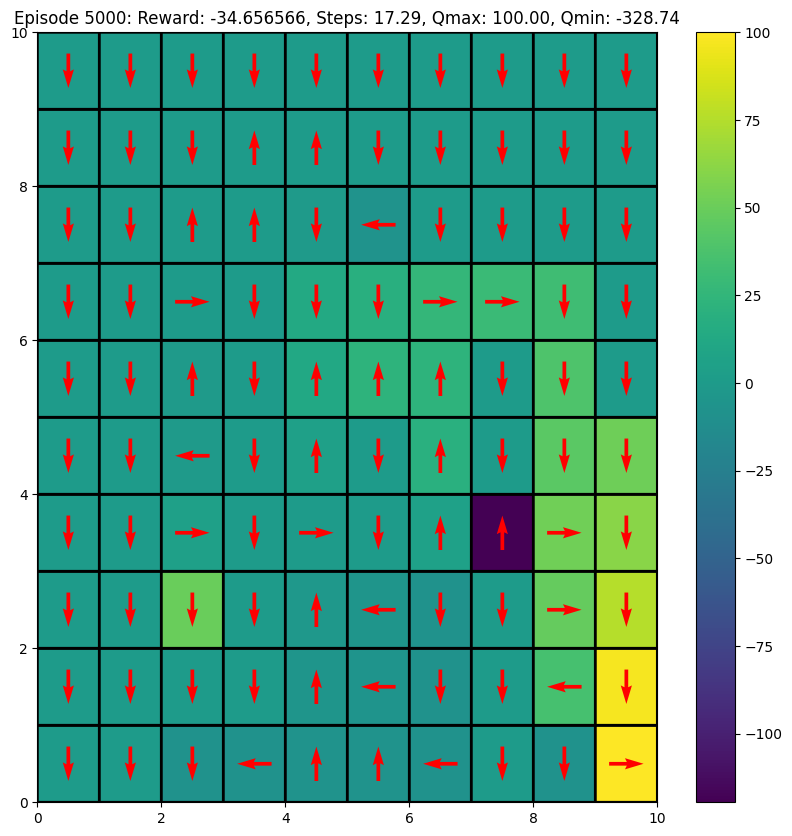

100%|██████████| 5000/5000 [00:11<00:00, 448.78it/s]


In [15]:
Q, rewards, steps = sarsa(gw_windy, Q_init, gamma = GAMMA, plot_heat=True, choose_action= choose_action_softmax)

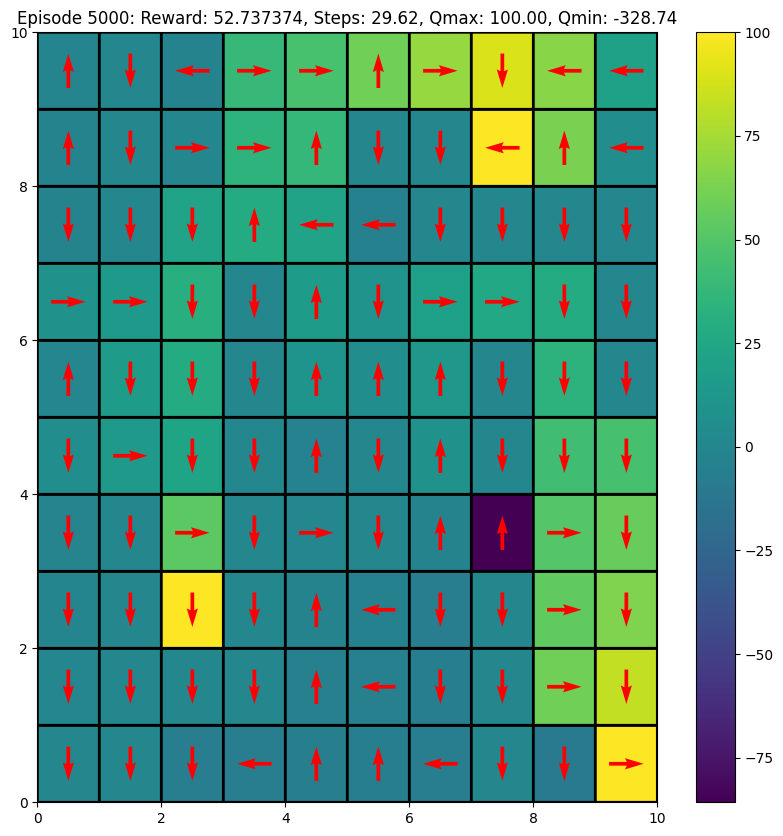

100%|██████████| 5000/5000 [00:12<00:00, 396.61it/s]


In [16]:
Q, rewards, steps = sarsa(gw, Q, gamma = GAMMA, plot_heat=True, choose_action= choose_action_softmax)

### Q-Learning

In [17]:
print_freq = 100
Q = np.zeros((gw.num_states, gw.num_actions))


def qlearning(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(EPISODES)
    steps_to_completion = np.zeros(EPISODES)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = EPSILON0
    alpha = ALPHA0
    for ep in tqdm(range(EPISODES)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        # print(state)
        # state_row_col = seq_to_col_row(state, env.num_cols)[0]
        # [x,y] = state_row_col
        action = choose_action(Q, state)
        
        
        while not env.done:
            
            state_next, reward= env.step(state,action)
            # state_next_row_col = seq_to_col_row(state_next, env.num_cols)[0]
            # [x_next, y_next] = state_next_row_col
            action_next = choose_action(Q, state_next)

            #Update Q
            Q[state, action] = Q[state, action] + alpha*( reward + gamma*np.max(Q[state_next]) - Q[state, action])
            
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion

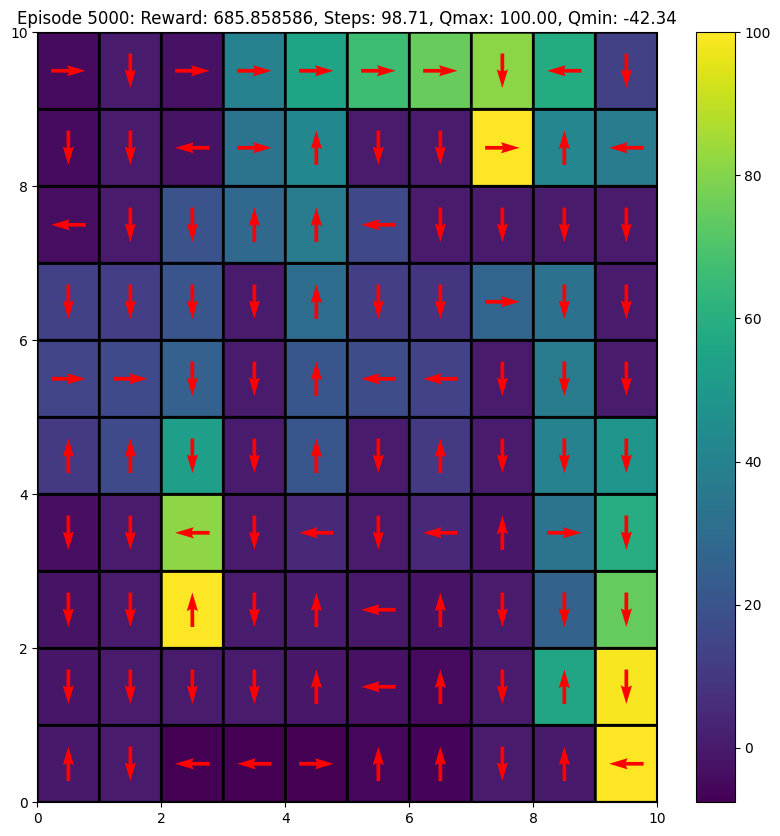

100%|██████████| 5000/5000 [00:31<00:00, 159.26it/s]


In [18]:
Q, rewards, steps = qlearning(env, Q, gamma = GAMMA, plot_heat=True, choose_action= choose_action_softmax)